# MUSER Imaging and deconvolution demonstration

This script makes a fake data set and then deconvolves it. Finally the full and residual visibility are plotted.

In [1]:
%matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

results_dir = '/tmp/'

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (8.0, 8.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u

from matplotlib import pyplot as plt


from rascil.data_models import PolarisationFrame
from astropy.coordinates import EarthLocation, SkyCoord, ITRS
from rascil.processing_components import create_configuration_from_file
from rascil.processing_components.visibility.coalesce import convert_visibility_to_blockvisibility, \
    convert_blockvisibility_to_visibility
from rascil.processing_components.visibility.base import create_blockvisibility_from_ms, create_visibility_from_ms
from rascil.processing_components import create_visibility, show_image, export_image_to_fits, \
    deconvolve_cube, restore_cube, create_named_configuration, create_test_image, \
    create_image_from_visibility, advise_wide_field, invert_2d, predict_2d
from fund import create_configuration
from muser.data_models.parameters import muser_path, muser_data_path, muser_output_path

import logging
from muser.data_models.parameters import muser_path
import os

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

mpl_logger = logging.getLogger("matplotlib") 
mpl_logger.setLevel(logging.WARNING) 




In [2]:
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

Construct LOW core configuration

In [7]:
location = EarthLocation(lon=115.2505 * u.deg, lat=42.211833333 * u.deg, height=1365.0 * u.m)

# conf_dir = muser_path('configurations')

# antfile = os.path.join(conf_dir, 'muser-1.csv')
# lowcore = create_configuration_from_file(antfile=antfile,
#              mount='altaz', names='MUSER_%d',
#              diameter=2.0, name='MUSER', location=location)

msfile = muser_output_path("CSRH_20151122-125000_100457483.ms")

ch= numpy.arange(1)
vis = create_blockvisibility_from_ms(msfile,  start_chan=52,end_chan=52)

from rascil.processing_components.flagging.operations import flagging_blockvisibility,flagging_blockvisibility_with_bl
bvis = flagging_blockvisibility(vis[0], antenna=[8,9,10,11,27])
baseline = [ [4,0],[4,1],[5,4],[21,4],[24,4],[25,4],[26,4],[27,4],[28,4],[29,4],[30,4],[31,4],[32,4],[36,4],[38,4],[39,4]]
baseline.append([[17,4],[17,13],[19,17],[26,17],[27,17],[28,17],[29,17],[30,17],[31,17],[39,17]])
bvis = flagging_blockvisibility_with_bl(vis[0],baseline)

# Flagging
vt = convert_blockvisibility_to_visibility(bvis)




create_blockvisibility_from_ms: {'type': 'Measurement Set', 'subType': '', 'readme': 'This is a MeasurementSet Table holding measurements from a Telescope\n'}
create_blockvisibility_from_ms: Reading unique fields [0], unique data descriptions [0]
create_blockvisibility_from_ms: Found 780 rows
create_blockvisibility_from_ms: Found 64 channels
create_blockvisibility_from_ms: Reading channels from 52 to 52
create_blockvisibility_from_ms: Observation from 2015-11-22 04:51:29.467 to 2015-11-22 04:51:29.467
convert_visibility: Original 1 rows, 0.000 GB, converted 780 rows, 0.000 GB


We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [8]:
advice = advise_wide_field(vt, guard_band_image=3.0, delA=0.1,
                           oversampling_synthesised_beam=4.0)
cellsize = advice['cellsize']

advise_wide_field: (max_wavelength) Maximum wavelength 0.176 (meters)
advise_wide_field: (min_wavelength) Minimum wavelength 0.176 (meters)
advise_wide_field: (maximum_baseline) Maximum baseline 16591.6 (wavelengths)
advise_wide_field: (maximum_w) Maximum w 16591.6 (wavelengths)
advise_wide_field: (diameter) Station/dish diameter 4.5 (meters)
advise_wide_field: (primary_beam_fov) Primary beam 0.0392 (rad) 2.25 (deg) 8.08e+03 (asec)
advise_wide_field: (image_fov) Image field of view 0.118 (rad) 6.74 (deg) 2.42e+04 (asec)
advise_wide_field: (synthesized_beam) Synthesized beam 6.03e-05 (rad) 0.00345 (deg) 12.4 (asec)
advise_wide_field: (cellsize) Cellsize 1.51e-05 (rad) 0.000863 (deg) 3.11 (asec)
advice_wide_field: (npixels) Npixels per side = 7802
advice_wide_field: (npixels2) Npixels (power of 2) per side = 8192
advice_wide_field: (npixels23) Npixels (power of 2, 3) per side = 8192
advice_wide_field: (npixels_min) Npixels (power of 2, 3, 4, 5) per side = 8192
advice_wide_field: (w_sampl

Plot the synthesized uv coverage.

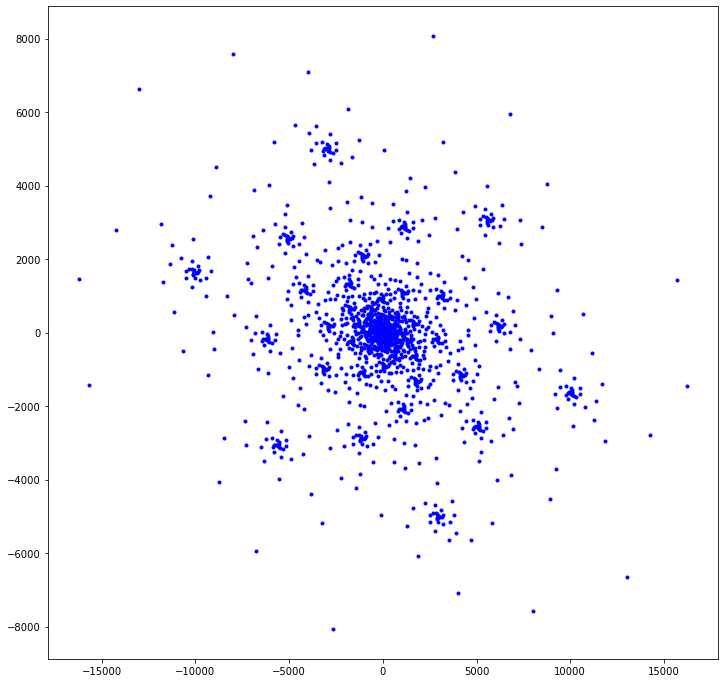

In [9]:
plt.clf()
plt.plot(vt.data['uvw'][:,0], vt.data['uvw'][:,1], '.', color='b')
plt.plot(-vt.data['uvw'][:,0], -vt.data['uvw'][:,1], '.', color='b')
# plt.xlim([-400.0, 400.0])
# plt.ylim([-400.0, 400.0])
plt.show()

Read the venerable test image, constructing an image

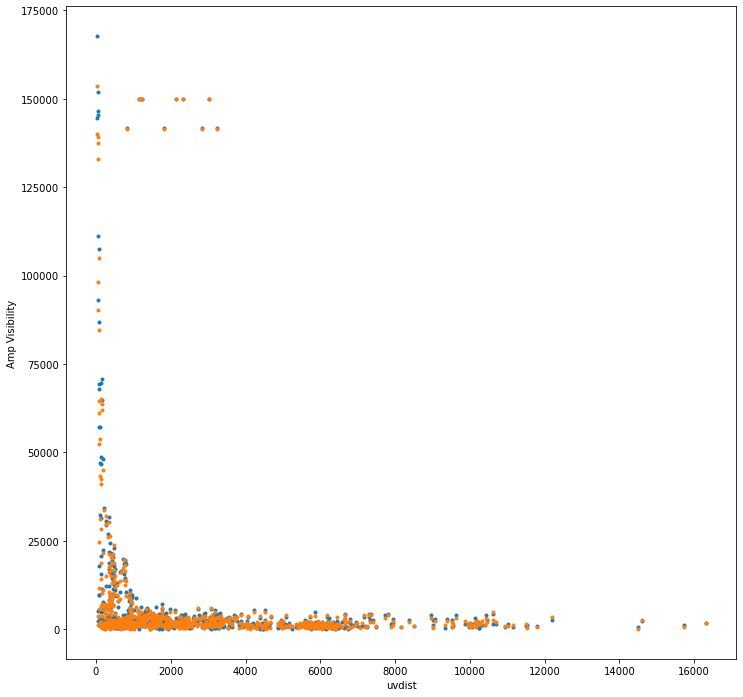

In [10]:
# To check that we got the prediction right, plot the amplitude of the visibility.
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis']), '.')
plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.show()

Make the dirty image and point spread function

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (237.35661765, -20.0515479)>, starting frequency 1700000000.0 Hz, and bandwidth 24999999.99975 Hz
create_image_from_visibility: uvmax = 16238.824426 wavelengths
create_image_from_visibility: Critical cellsize = 0.000031 radians, 0.001764 degrees
create_image_from_visibility: Cellsize          = 1.50678e-05 radians, 0.000863323 degrees
create_image_from_visibility: image shape is [1, 2, 1024, 1024]


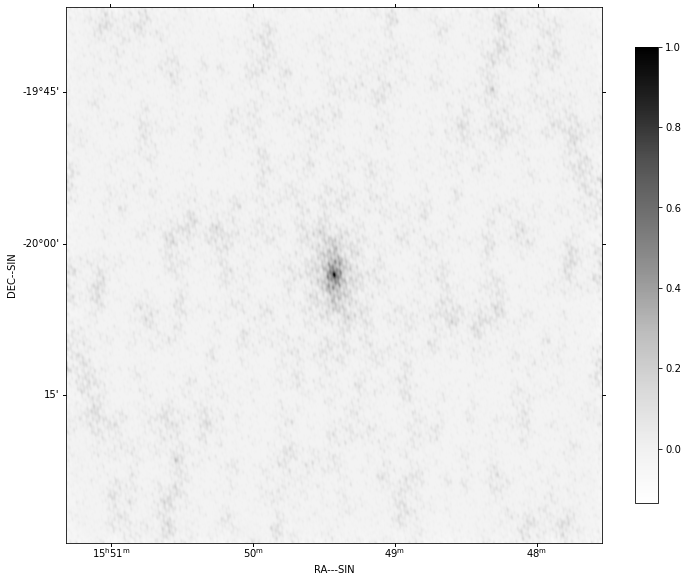

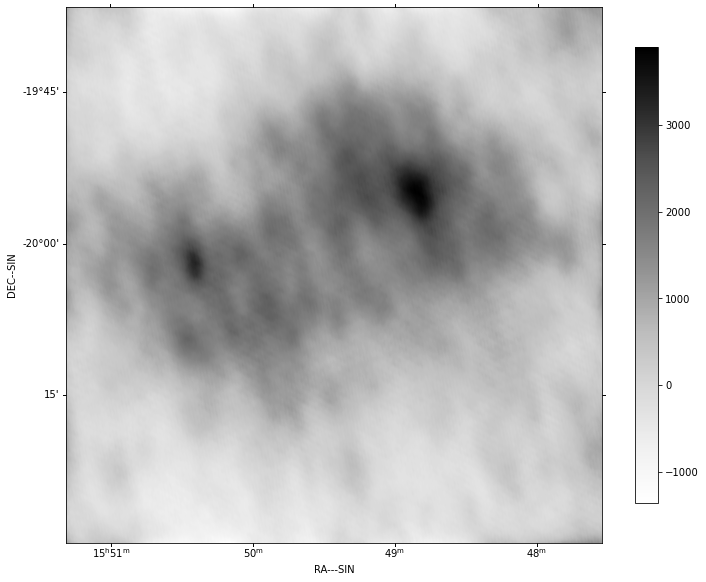

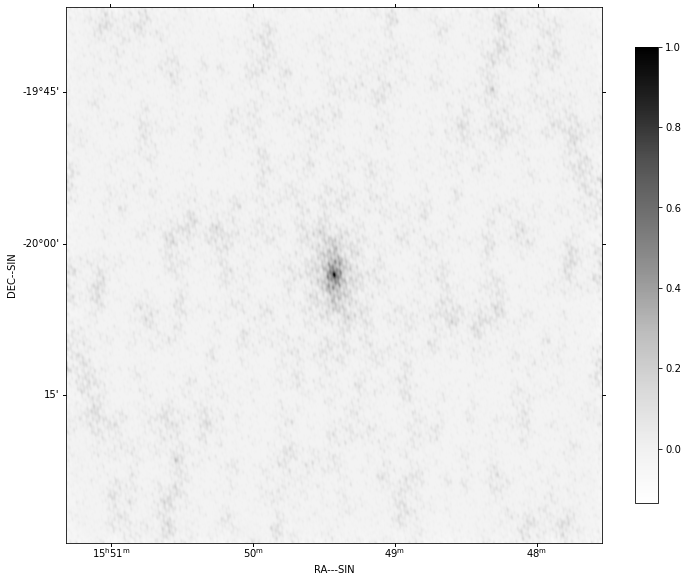

In [11]:
model = create_image_from_visibility(vt, cellsize=cellsize, npixel=1024, polarisation_frame=PolarisationFrame('circularnp'))
dirty, sumwt = invert_2d(vt, model, context='2d')
psf, sumwt = invert_2d(vt, model, context='2d', dopsf=True)

show_image(dirty)
show_image(psf)
# print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirty.data.max(), dirty.data.min(), sumwt))

# print("Max, min in PSF         = %.6f, %.6f, sumwt = %f" % (psf.data.max(), psf.data.min(), sumwt))

# export_image_to_fits(dirty, '%s/imaging_dirty.fits'%(results_dir))
# export_image_to_fits(psf, '%s/imaging_psf.fits'%(results_dir))

Deconvolve using clean

deconvolve_cube : Cleaning entire image
deconvolve_cube : PSF support = +/- 512 pixels
deconvolve_cube : PSF shape (1, 2, 1024, 1024)
deconvolve_cube : Multi-scale clean of each polarisation and channel separately
deconvolve_cube : Processing pol 0, channel 0
msclean : Peak of PSF = 1.0 at (512, 512)
msclean : Peak of Dirty = 3906.910699 Jy/beam at (671, 667) 
msclean : Coupling matrix =
 [[1.         0.99049253 0.87762477 0.60401107]
 [0.99049253 0.98135847 0.87232248 0.60329012]
 [0.87762477 0.87232248 0.80441385 0.59280927]
 [0.60401107 0.60329012 0.59280927 0.52763531]]
msclean : Max abs in dirty Image = 3906.910699 Jy/beam
msclean : Start of minor cycle
msclean : This minor cycle will stop at 300 iterations or peak < 3.906911 (Jy/beam)
msclean : Timing for setup: 1.584 (s) for dirty shape (1024, 1024), PSF shape (1024, 1024) , scales [0, 3, 10, 30]
msclean : Minor cycle 0, peak [3868.14465238 3869.06958184 3875.35324426 3854.05107411] at [671, 669, 3]
msclean : Minor cycle 30, pea

Text(0.5, 1.0, 'Restored')

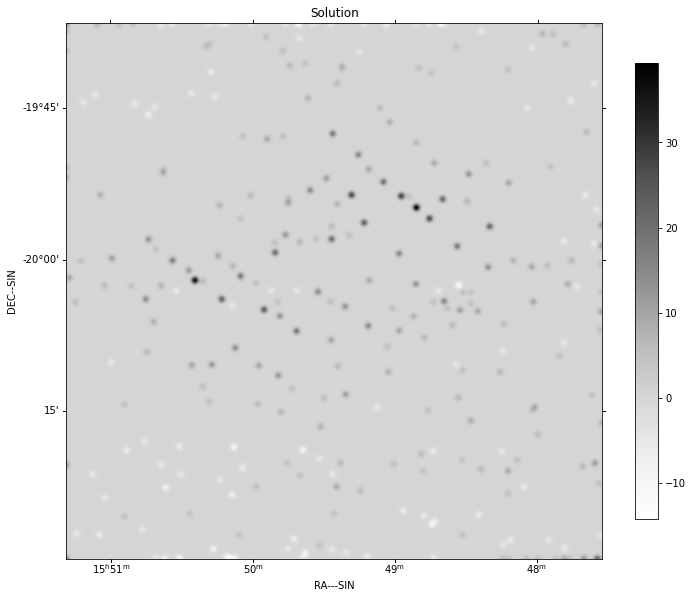

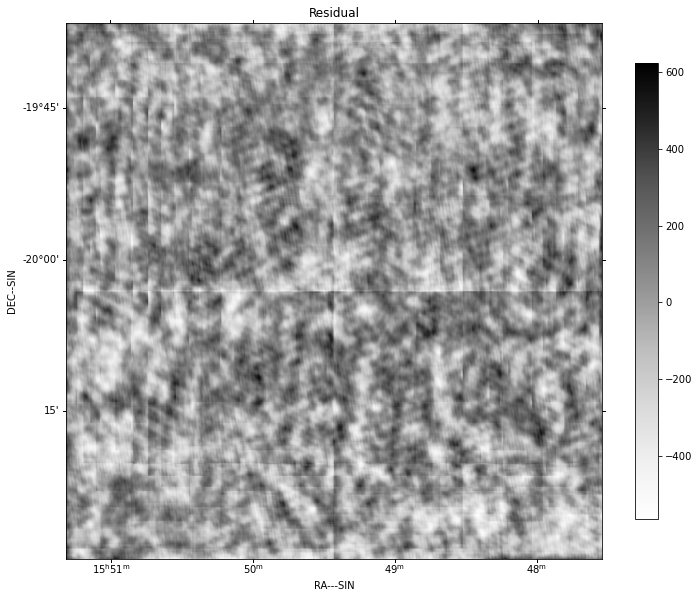

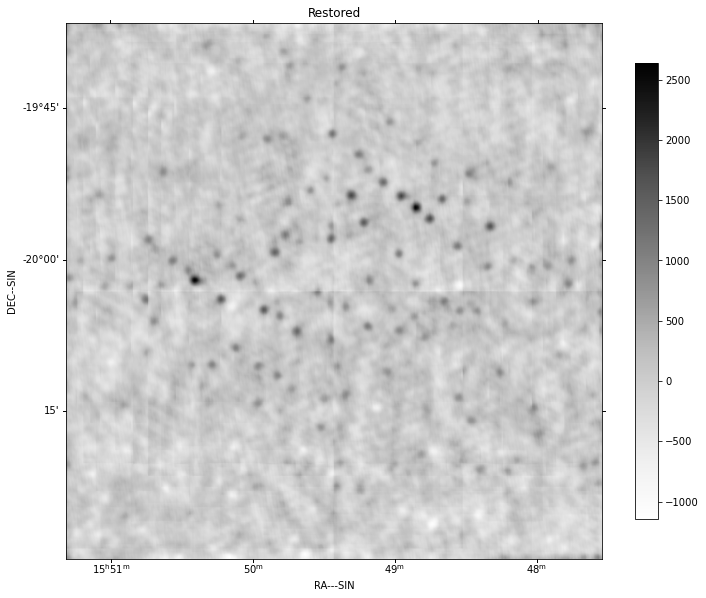

In [12]:
comp, residual = deconvolve_cube(dirty, psf, niter=300, threshold=0.001, fractional_threshold=0.001,
                                 gain=0.7,algorithm='msclean',scales=[0, 3, 10, 30])

restored = restore_cube(comp, psf, residual)

# Show the results

fig=show_image(comp)
plt.title('Solution')
fig=show_image(residual)
plt.title('Residual')
fig=show_image(restored)
plt.title('Restored')

Predict the visibility of the model

Now we will plot the original visibility and the residual visibility.